# Quick Start - pyCityLayers

# Access to Internal (CERC) Data

#### --------------------------------------------------------------------------------------------------------------------------------------------------------

In [1]:
import numpy as np
import json
from pprint import pprint
import fiona
from shapely.geometry import Polygon, Point, MultiPolygon
from pycitylayers.client import Client
from pycitylayers.utils import PointGQL, PolygonGQL
import pycitylayers

### Create an instance of connection to database

In [2]:
client = Client().create(source='cerc')

Fetching Metadata. Please Wait ...


### Querying for all collections available in the database

In [3]:
coll = client.collection
pprint(coll)

---------- Data Collection ----------
Source:		cerc 
Datasets Count:	16


### Show all datasets in the collection

In [4]:
coll.datasets

[---------- Dataset ----------
 Name:		agents 
 Tables Count:	1 ,
 ---------- Dataset ----------
 Name:		agents_by_pk 
 Tables Count:	1 ,
 ---------- Dataset ----------
 Name:		bixi_stations 
 Tables Count:	1 ,
 ---------- Dataset ----------
 Name:		bixi_trips 
 Tables Count:	1 ,
 ---------- Dataset ----------
 Name:		building_footprint_ms 
 Tables Count:	1 ,
 ---------- Dataset ----------
 Name:		building_footprint_mtl 
 Tables Count:	1 ,
 ---------- Dataset ----------
 Name:		building_lots 
 Tables Count:	1 ,
 ---------- Dataset ----------
 Name:		census_divisions 
 Tables Count:	1 ,
 ---------- Dataset ----------
 Name:		census_subdivisions 
 Tables Count:	1 ,
 ---------- Dataset ----------
 Name:		census_tracts 
 Tables Count:	1 ,
 ---------- Dataset ----------
 Name:		dissemination_areas 
 Tables Count:	1 ,
 ---------- Dataset ----------
 Name:		dissemination_blocks 
 Tables Count:	1 ,
 ---------- Dataset ----------
 Name:		ev_stations 
 Tables Count:	1 ,
 ---------- Dataset -----

In [5]:
ds = coll[2]
ds

---------- Dataset ----------
Name:		bixi_stations 
Tables Count:	1 

### Show all tables in a dataset

In [6]:
ds.tables

[---------- Table:0 ----------
 Name:		bixi_stations 
 Description:	 
 Format:		CSV ]

### Show all columns in a table

In [17]:
tb = ds[0]
columns = tb.columns
pprint(columns)

['borough_id',
 'building_number',
 'built_area',
 'dwelling_number',
 'firstletter_apt',
 'geom',
 'index',
 'land_area',
 'landuse_code',
 'landuse_text',
 'lastletter_apt',
 'max_floors',
 'municipality_code',
 'nad83_registration',
 'street_name',
 'street_number',
 'uid',
 'unit_category',
 'unit_number',
 'year_built']


In [18]:
sql_string = f'SELECT "borough_id", "built_area" FROM "{tb._id}" LIMIT 6 '
print(sql_string)

data = tb.query_sql(sql_string)

data

SELECT "borough_id", "built_area" FROM "None" LIMIT 6 


AttributeError: 'GQLTable' object has no attribute 'query_sql'

### Get N rows from a table given a list of columns 

In [8]:
query_options = {
    'columns': ['code', 'geom', 'index', 'name', 'year'], 
    'nrows': 500, 
    'skiprows': 0,
}

data = tb.query_simple( columns=['code', 'geom', 'index', 'name', 'year'], nrows=500 )
# data = tb.query_simple( **query_options )

print("Table Size: ", data.shape)
data


Table Size:  (500, 5)


,code,geom,index,name,year
0,6164,"{'type': 'Point', 'crs': {'type': 'name', 'pro...",0,Chambord / Laurier,2015
1,6216,"{'type': 'Point', 'crs': {'type': 'name', 'pro...",1,Parc Jeanne Mance (monument George-Étienne Car...,2015
2,6192,"{'type': 'Point', 'crs': {'type': 'name', 'pro...",2,Berri / St-Grégoire,2015
3,6158,"{'type': 'Point', 'crs': {'type': 'name', 'pro...",3,Gilford / Brébeuf,2015
4,6140,"{'type': 'Point', 'crs': {'type': 'name', 'pro...",4,Marquette / Rachel,2015
...,...,...,...,...,...
495,6027,"{'type': 'Point', 'crs': {'type': 'name', 'pro...",35,de Maisonneuve / Mansfield (sud),2019
496,6029,"{'type': 'Point', 'crs': {'type': 'name', 'pro...",36,Bourget / St-Jacques,2019
497,6031,"{'type': 'Point', 'crs': {'type': 'name', 'pro...",37,de Maisonneuve / Robert-Bourassa,2019
498,6032,"{'type': 'Point', 'crs': {'type': 'name', 'pro...",38,Métro Place-d'Armes (Viger / St-Urbain),2019


(45.35, 45.75)

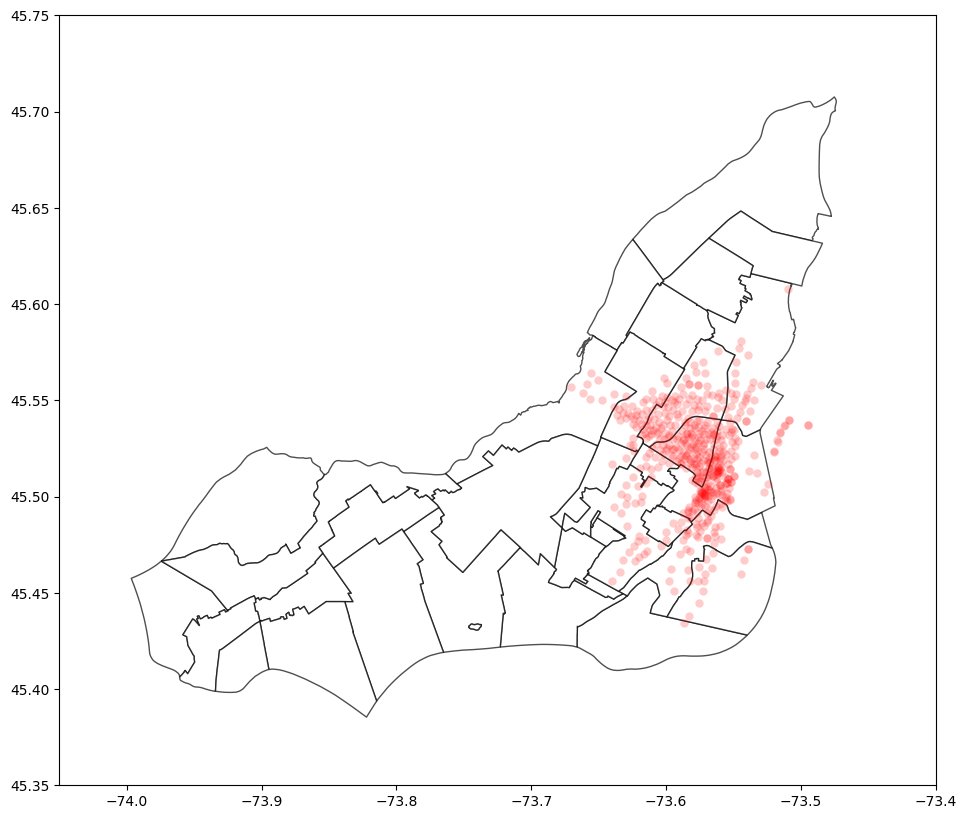

In [10]:
import geopandas as gpd
import matplotlib.pyplot as plt

list_of_points = [ Point(row['geom']['coordinates']) for _, row in data.iterrows() ]

gdf = gpd.GeoDataFrame(index=list(range(len(list_of_points))), crs='epsg:4326', geometry=list_of_points)

# load neighbourhood shape file
mtl_neighs = gpd.read_file('montreal_neighs.geojson')


fig, ax = plt.subplots(figsize=(12, 10))
mtl_neighs.plot(ax=ax, color=None, alpha=0.69, facecolor='white', edgecolor='black', linewidth=1)
gdf.plot(ax=ax, color='r', alpha=0.2, facecolor='red', edgecolor=None, linewidth=0)

ax.set_xlim(-74.05, -73.4)
ax.set_ylim(45.35, 45.75)



### Get N rows from a table given a list of columns and distance to a point

In [11]:
query_geometry = PointGQL().point(-73.64453315734863,45.46627091868821)
print( query_geometry )


query_options = {
    'columns': ['code', 'name', 'year'], 
    'nrows': 500, 
    'skiprows': 0,
    'geometry_operation': 'distance_from_point',
    'geom_distance': 0.015,
    'geometry': query_geometry,
    'crs_epsg': 4326,
}

data = tb.query_simple( **query_options )

print("Table Size: ", data.shape)
data


{'geometry': {'type': 'Point', 'coordinates': [-73.64453315734863, 45.46627091868821], 'crs': {'type': 'name', 'properties': {'name': 'EPSG:4326'}}}}
Table Size:  (31, 3)


,code,name,year
0,6115,Benny / Monkland,2015
1,6369,West Broadway / Sherbrooke,2015
2,6719,Park Row O / Sherbrooke,2015
3,6115,Benny / de Monkland,2019
4,6369,U. Concordia - Campus Loyola (Sherbrooke / Wes...,2019
5,6719,Park Row O / Sherbrooke,2019
6,7102,Grand Boulevard / de Terrebonne,2019
7,6115,Benny / de Monkland,2020
8,6369,U. Concordia - Campus Loyola (Sherbrooke / Wes...,2020
9,6719,Park Row O / Sherbrooke,2020


In [12]:
ds = coll.search(by_name="lots")[0]
tb = ds[0]
tb

---------- Table:0 ----------
Name:		building_lots 
Description:	 
Format:		CSV 

In [13]:
query_geometry = PointGQL().point(-73.64453315734863,45.46627091868821)
print( query_geometry )


query_options = {
    'columns': ['index', 'built_area', 'geom', 'year_built'], 
    'nrows': 10000, 
    'skiprows': 0,
    'geometry_operation': 'distance_from_point',
    'geom_distance': 0.005,
    'geometry': query_geometry,
    'crs_epsg': 4326,
}

data = tb.query_simple( **query_options )

print("Table Size: ", data.shape)
data


{'geometry': {'type': 'Point', 'coordinates': [-73.64453315734863, 45.46627091868821], 'crs': {'type': 'name', 'properties': {'name': 'EPSG:4326'}}}}
Table Size:  (1126, 4)


,index,built_area,geom,year_built
0,7695,187,"{'type': 'Polygon', 'crs': {'type': 'name', 'p...",1950
1,9799,2893,"{'type': 'Polygon', 'crs': {'type': 'name', 'p...",2019
2,13099,284,"{'type': 'Polygon', 'crs': {'type': 'name', 'p...",1955
3,13128,293,"{'type': 'Polygon', 'crs': {'type': 'name', 'p...",1952
4,15743,187,"{'type': 'Polygon', 'crs': {'type': 'name', 'p...",1947
...,...,...,...,...
1121,334170,240,"{'type': 'Polygon', 'crs': {'type': 'name', 'p...",1954
1122,334373,194,"{'type': 'Polygon', 'crs': {'type': 'name', 'p...",1953
1123,334457,184,"{'type': 'Polygon', 'crs': {'type': 'name', 'p...",1951
1124,334487,187,"{'type': 'Polygon', 'crs': {'type': 'name', 'p...",1951


In [16]:
import geopandas as gpd
import matplotlib.pyplot as plt

list_of_polygons = [Polygon([Point(el) for el in poly['geom']['coordinates'][0]]) for _,poly in data.iterrows()]

gdf = gpd.GeoDataFrame(index=list(range(len(data))), crs='epsg:4326', geometry=list_of_polygons)

gdf.plot(color='r', alpha=0.7, facecolor='white', edgecolor='black', linewidth=2, figsize=(12,12))


ValueError: Inconsistent coordinate dimensionality

### Get N rows from a table given a list of columns and within a polygon

In [ ]:
query_geometry = PolygonGQL().rect_from_two_corners([-73.643610,45.468896], [-73.623610,45.458896])
print( query_geometry )


query_options = {
    'columns': ['index', 'built_area', 'geom', 'year_built'], 
    'nrows': 10000, 
    'skiprows': 0,
    'geometry_operation': 'is_within_poly',
    'geometry': query_geometry,
    'crs_epsg': 4326,
}

data = tb.query_simple( **query_options )

print("Table Size: ", data.shape)
data

## visualize results

In [ ]:
import geopandas as gpd
import matplotlib.pyplot as plt

def rgb(minimum, maximum, value):
    if value < minimum: value = minimum
    if value > maximum: value = maximum
    minimum, maximum = float(minimum), float(maximum)
    ratio = 2 * (value-minimum) / (maximum - minimum)
    b = int(max(0, 255*(1 - ratio)))
    r = int(max(0, 255*(ratio - 1)))
    g = 255 - b - r
    return [r/255, g/255, b/255]

list_of_polygons = [Polygon([Point(el) for el in poly['geom']['coordinates'][0]]) for _, poly in data.iterrows()]

gdf = gpd.GeoDataFrame(index=list(range(len(data))), crs='epsg:4326', geometry=list_of_polygons)
colors = data['year_built'].apply(lambda x: rgb(1900,2020,x))
gdf.plot(color=colors, alpha=0.7, facecolor='white', edgecolor='black', linewidth=2, figsize=(12,12))



## Save as file

In [15]:
from pathlib import Path  
filepath = Path('folder/subfolder/out.csv')  
filepath.parent.mkdir(parents=True, exist_ok=True)  
df.to_csv(filepath)

NameError: name 'df' is not defined